In [10]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt


In [11]:
def eu_call_price(S_0, K, T, r, sigma):
    d_plus = 1/(sigma * np.sqrt(T)) * (np.log(S_0/K) + (r + 0.5*sigma**2)*T)
    d_minus = d_plus - sigma * np.sqrt(T)
    C = scipy.stats.norm.cdf(d_plus) * S_0 - scipy.stats.norm.cdf(d_minus) * K * np.exp(-r * T)
    return C

def eu_put_price(S_0, K, T, r, sigma):
    C = eu_call_price(S_0, K, T, r, sigma)
    P = K * np.exp(-r*T) - S_0 + C
    return P

call_price = eu_call_price(90, 100, 1, 0.04, 0.15)
put_price = eu_put_price(90, 100, 1, 0.04, 0.15)
print(call_price, put_price)

3.0415722887553294 9.120516203987645


In [18]:
def MC_EU_call(S_0, K, T, r, sigma, N, M):
    dt = T/N
    discount_factor = np.exp(-r * T)
    S_paths = np.zeros((M, N+1))
    S_paths[:, 0] = S_0

    for i in range(1, N+1):
        Z = np.random.randn(M)
        S_paths[:, i] = S_paths[:, i - 1] * np.exp((r - 0.5*sigma**2) * dt + sigma* np.sqrt(dt) * Z)

    S_terminal = S_paths[:, -1]

    payoffs = np.maximum(S_terminal - K, 0)
    option_price = discount_factor * np.mean(payoffs)

    return option_price

def MC_option_prices(S_0, K, T, r, sigma, N, M):

    call = MC_EU_call(S_0, K, T, r, sigma, N, M)
    put = K * np.exp(-r*T) - S_0 + call_price

    return call, put

call, put = MC_option_prices(90, 100, 1, 0.04, 0.15, 5000, 400000)
print(call, put)

3.0529365934284405 9.128670660228405


Let's write the black-scholes PDE above:

$\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + rS\frac{\partial V}{\partial S} - rV = 0$

In [ ]:
def price_european_option(S0, K, T, r, sigma, Smax, M, N, option_type='call'):
    """
    S0: Current price
    K: Strike
    T: Time to maturity
    r: risk free
    sigma: vol
    Smax: Maximum asset price considered in the grid
    M: number of spatial grid steps
    N: number of time steps
    """
    dS = Smax/M
    dt = T / N
    S_grid = np.linspace(0, Smax, M + 1)
    option_type = option_type.lower()
    if option_type == 'call':
        V = np.maximum(S_grid - K, 0)
    else:
        V = np.maximum(K - S_grid, 0)

    # Backward time-stepping from expirty t=T to t=0
    for j in range(N):
        t = T - j * dt

        # Apply boundary conditions
        if option_type=='call':
            V[0] = 0
            V[-1] = Smax - K * np.exp(-r * (t - dt))
        else:
            V[0] = K * np.exp(-r * (t - dt))
            V[-1] = 0
        
        # Set up the tridiagonal system for the interior nodes
        A = np.zeros((M-1, M-1))
        B = np.zeros(M-1)
        for i in range(1, M):
            a = 0.25 * dt * (sigma**2 * i**2 - r*i)
            b = -0.5 * dt * (sigma**2 * i**2 + r)
            c = 0.25 * dt * (sigma**2 * i*2 + r * i)

            A[i-1, i-1] = 1-b
            




European Call Price: 3.0418


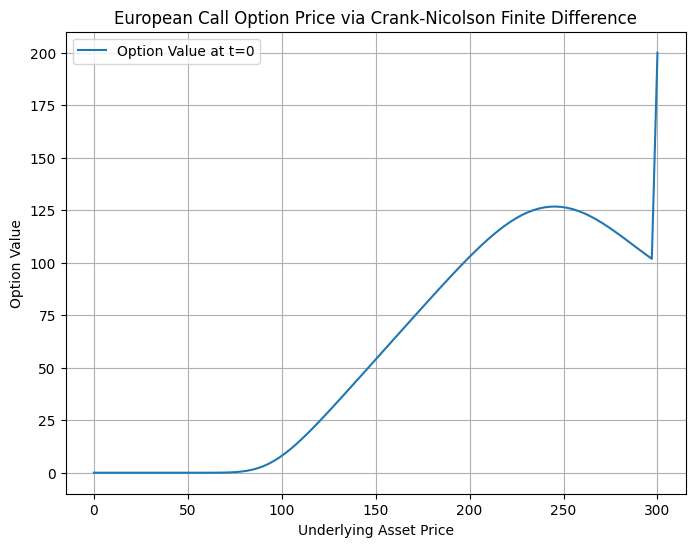

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def price_european_option_crank_nicolson(S0, K, T, r, sigma, Smax, M, N, option_type='call'):
    """
    Prices a European option using the Crank-Nicolson finite difference method.

    Parameters:
      S0         : Current underlying asset price.
      K          : Strike price.
      T          : Time to maturity.
      r          : Risk-free interest rate.
      sigma      : Volatility of the underlying asset.
      Smax       : Maximum asset price considered in the grid.
      M          : Number of spatial grid steps.
      N          : Number of time steps.
      option_type: 'call' or 'put'.

    Returns:
      price : The option price interpolated at S0.
      S_grid: The grid of underlying asset prices.
      V     : Option values at time t=0 across the grid.
    """
    # Discretization parameters
    dS = Smax / M
    dt = T / N
    S_grid = np.linspace(0, Smax, M + 1)
    
    # Terminal condition at t=T (option payoff)
    if option_type.lower() == 'call':
        V = np.maximum(S_grid - K, 0)
    else:  # put option
        V = np.maximum(K - S_grid, 0)
    
    # Backward time-stepping: from expiry T to time 0
    for j in range(N):
        # current time (we are stepping backwards, so t decreases)
        t = T - j * dt
        
        # Apply boundary conditions for the next time level (t - dt)
        if option_type.lower() == 'call':
            V[0] = 0
            V[-1] = Smax - K * np.exp(-r * (t - dt))
        else:
            V[0] = K * np.exp(-r * (t - dt))
            V[-1] = 0
        
        # Set up the tridiagonal system for the interior nodes (i=1,...,M-1)
        A = np.zeros((M - 1, M - 1))
        B = np.zeros(M - 1)
        
        for i in range(1, M):
            # Compute coefficients based on grid index i (S = i*dS)
            a = 0.25 * dt * (sigma**2 * i**2 - r * i)
            b = -0.5 * dt * (sigma**2 * i**2 + r)
            c = 0.25 * dt * (sigma**2 * i**2 + r * i)
            
            # Build the matrix A for the implicit part:
            # Diagonal element
            A[i - 1, i - 1] = 1 - b
            # Sub-diagonal (if applicable)
            if i > 1:
                A[i - 1, i - 2] = -a
            # Super-diagonal (if applicable)
            if i < M - 1:
                A[i - 1, i] = -c
            
            # Right-hand side using the explicit part
            B[i - 1] = a * V[i - 1] + (1 + b) * V[i] + c * V[i + 1]
        
        # Solve the linear system A * V_new = B for the interior points
        V_new_interior = np.linalg.solve(A, B)
        V[1:M] = V_new_interior
    
    # Interpolate to get the price at the current asset price S0
    price = np.interp(S0, S_grid, V)
    return price, S_grid, V

# Example usage:

# Option and model parameters
S0 = 90        # Current asset price
K = 100        # Strike price
T = 1.0        # Time to maturity (in years)
r = 0.04       # Risk-free rate (5%)
sigma = 0.15    # Volatility (20%)
Smax = 300     # Maximum asset price for the grid
M = 100        # Number of spatial steps
N = 1000       # Number of time steps

# Price a European call option
price, S_grid, V = price_european_option_crank_nicolson(S0, K, T, r, sigma, Smax, M, N, option_type='call')
print("European Call Price: {:.4f}".format(price))

# Plot the option price as a function of the underlying asset price at time t=0
plt.figure(figsize=(8, 6))
plt.plot(S_grid, V, label='Option Value at t=0')
plt.xlabel('Underlying Asset Price')
plt.ylabel('Option Value')
plt.title('European Call Option Price via Crank-Nicolson Finite Difference')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
price

np.float64(3.0417924015090314)

In [12]:
call_price

np.float64(3.0415722887553294)

array([0.00000000e+00, 2.99527829e-28, 2.60714977e-25, 8.00918877e-23,
       1.24473893e-20, 1.15122790e-18, 6.96681525e-17, 2.93759930e-15,
       9.02767306e-14, 2.09192745e-12, 3.75426076e-11, 5.33290953e-10,
       6.10635477e-09, 5.72500893e-08, 4.45576449e-07, 2.91464945e-06,
       1.62062396e-05, 7.74084159e-05, 3.20798720e-04, 1.16454402e-03,
       3.73724297e-03, 1.06976770e-02, 2.75504460e-02, 6.43745664e-02,
       1.37584999e-01, 2.71075092e-01, 4.96034482e-01, 8.49017587e-01,
       1.36838216e+00, 2.08978923e+00, 3.04179240e+00, 4.24250927e+00,
       5.69800981e+00, 7.40255392e+00, 9.34036181e+00, 1.14883356e+01,
       1.38190953e+01, 1.63038025e+01, 1.89144326e+01, 2.16253570e+01,
       2.44142495e+01, 2.72624290e+01, 3.01547904e+01, 3.30794764e+01,
       3.60274164e+01, 3.89918264e+01, 4.19677317e+01, 4.49515437e+01,
       4.79407048e+01, 5.09334017e+01, 5.39283370e+01, 5.69245501e+01,
       5.99212738e+01, 6.29178151e+01, 6.59134496e+01, 6.89073217e+01,
      